# **Multi-target: Road to the Top, Part 4**

This notebook has been prepared by me and is based on the fast.ai's Notebook, which can be found at the following link: https://www.kaggle.com/code/jhoward/multi-target-road-to-the-top-part-4.

Review it for a comprehensive explanation.

## **Introduction**

In [19]:
creds = '{"username":"","key":""}'

In [20]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [21]:
!pip install fastkaggle

In [22]:
!pip install timm

In [23]:
from fastkaggle import *
import timm
from fastai.vision.all import *

In [24]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [25]:
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/sample_submission.csv')]

## **Multi-output DataLoader**

In [26]:
from fastcore.parallel import *
trn_path = path/'train_images'

In [27]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [28]:
df.loc['100330.jpg', 'variety']

'ADT45'

In [29]:
def get_variety(p): return df.loc[p.name, 'variety']

In [30]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(trn_path)

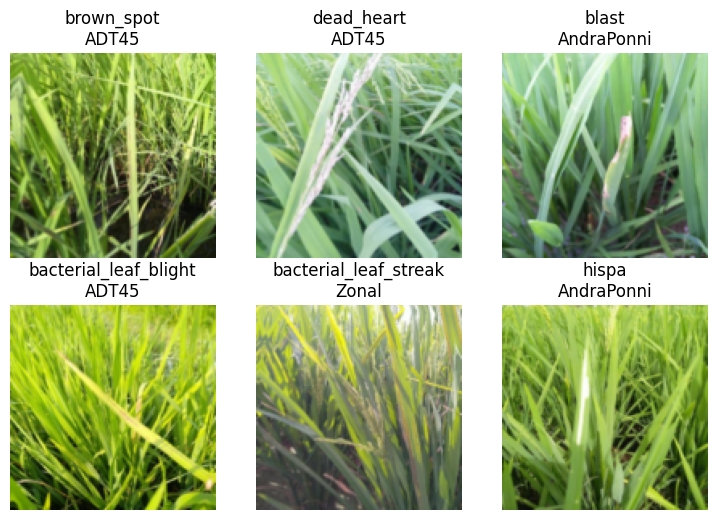

In [31]:
dls.show_batch(max_n=6)

## **Replicating the disease model**

In [32]:
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

In [33]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


In [34]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.266005,0.706201,0.227775,01:34


epoch,train_loss,valid_loss,disease_err,time
0,0.639526,0.415273,0.140317,01:29
1,0.509921,0.384208,0.125901,01:26
2,0.303530,0.216984,0.075444,01:28
3,0.183775,0.124245,0.037001,01:29
4,0.130028,0.119174,0.035560,01:29


## **Multi-target model**

In [35]:
learn = vision_learner(dls, arch, n_out=20).to_fp16()

In [36]:
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)

In [37]:
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)

In [38]:
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)

In [39]:
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

In [40]:
all_metrics = err_metrics+(disease_loss,variety_loss)

In [41]:
learn = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [42]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.292347,1.299024,0.267660,0.136473,0.835643,0.463381,01:24


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.063789,0.567869,0.131667,0.060548,0.377104,0.190765,01:30
1,0.760832,0.487083,0.109082,0.052859,0.322240,0.164842,01:27
2,0.475982,0.235664,0.049495,0.024507,0.155906,0.079758,01:30
3,0.290657,0.146433,0.039404,0.008650,0.114193,0.032240,01:29
4,0.187824,0.143666,0.041807,0.009611,0.114646,0.029020,01:29
